# Initialize data sources

In [334]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML
import us

# https://healthdata.gov/dataset/covid-19-reported-patient-impact-and-hospital-capacity-state-timeseries
hhs_data = pd.read_csv('https://healthdata.gov/sites/default/files/reported_hospital_utilization_timeseries_20201206_2146.csv', parse_dates=['date']).set_index(['state', 'date']).sort_index()

can_data = pd.read_csv('https://api.covidactnow.org/v2/states.timeseries.csv?apiKey=dd3c11e7428f4663a734092ee4158862', parse_dates=['date']).set_index(['state', 'date']).sort_index()
can_summary = pd.read_csv('https://api.covidactnow.org/v2/states.csv?apiKey=dd3c11e7428f4663a734092ee4158862').set_index(['state']).sort_index()

# Default utilization to use (before decomp) if there isn't a location-specific
# value in the API.
DEFAULT_ICU_UTILIZATION = 0.75

DEFAULT_ICU_DECOMP = 0.21

NJ_CORRECTION = 0.176 - 0.57 + DEFAULT_ICU_DECOMP
# https://trello.com/c/T15w5VLq/418-nj-icu-occupancy-rate-nonsensical
# This is temporarily correcting for incorrect typical occupancy rate by
# applying the shim in the decom override. It is negative, because we want
# to say that the expect ICU occupancy is greater than the reported ICU occupancy
# since CCM currently reports typical occupancy at 0.176 when they should be
# reporting something closer to the historical 0.57 from the 2018 source data
# they draw from.

ICU_DECOMP_OVERRIDE = {
    "AL": 0.15,
    "AZ": 0.4,
    "DE": 0.3,
    "DC": 0.15,
    "GA": 0.1,
    # TODO(https://trello.com/c/1ddB5ntl/): CCM is currently giving us an
    # extra-high utilization rate. If that gets fixed we may need to bump this
    # back down.
    "MS": 0.37,
    "NV": 0.25,
    "RI": 0,
    "NJ": NJ_CORRECTION,
    "UT": 0,  # https://trello.com/c/u8surBE7/533-small-icu-headroom-update-update-utah-decompensation-factor-to-align-with-local-sources
}

def calc_decomp(state):
    if state in ICU_DECOMP_OVERRIDE:
        return ICU_DECOMP_OVERRIDE[state]
    else:
        return DEFAULT_ICU_DECOMP
    

GREEN='#C4ECAA'
YELLOW='#FFFFC0'
ORANGE='#F7C000'
RED='#FA6261'

# Merge / massage data sources into a cleaner data set.

In [335]:
# Merge the timeseries (hhs_data and can_data) first so we get the full set of dates in the index.
hhs_can_merged=hhs_data.join(can_data, how='outer', rsuffix='_can')

In [336]:
# Add CAN summary data.
hhs_can_summary_merged=hhs_can_merged.join(can_summary, on='state', rsuffix='_summary')
data=hhs_can_summary_merged

In [337]:
# Add decomp data.
hhs_can_summary_merged['can_icu_decomp'] = hhs_can_merged.index.to_series().apply(lambda indexEntry: calc_decomp(indexEntry[0]))

In [338]:
# Fill in missing timeseries capacity / typical usage rate data using summary data.
hhs_can_summary_merged['actuals.icuBeds.capacity'] = data['actuals.icuBeds.capacity'].fillna(data['actuals.icuBeds.capacity_summary'])
hhs_can_summary_merged['actuals.icuBeds.typicalUsageRate'] = data['actuals.icuBeds.typicalUsageRate'].fillna(data['actuals.icuBeds.typicalUsageRate_summary']).fillna(DEFAULT_ICU_UTILIZATION)

In [339]:
data = hhs_can_summary_merged

# Helper funcs to get latest values and plot worst states.

In [340]:
def worst_states(column, count=10):
    current_data=data.groupby('state').last()
    return current_data.nlargest(count, column).index.tolist()

def plot_worst_states(column, title, count=10, start_date=None, **plot_args):
    worst_states_list = worst_states(column, count)
    display('Worst States:', worst_states_list)
    worst_states_data = data[data.index.get_level_values('state').isin(worst_states_list)]

    d = worst_states_data[column].reset_index('state').pivot(columns='state', values=column)
    if start_date != None:
        d = d[d.index > pd.to_datetime(start_date)]

    d.plot(figsize=(12, 8), linewidth=3, title=title, grid=True, **plot_args)

# ICU Headroom via CAN data (should match website).

In [341]:
# This is a manual recreation of the metric, mostly to prove that I know how it is computed and can muck with it.
data['can_icu_noncovid_estimate'] = data['actuals.icuBeds.capacity'] * ((data['actuals.icuBeds.typicalUsageRate']-data['can_icu_decomp']).clip(0))
data['can_icu_headroom'] = data['actuals.icuBeds.capacity'] - data['can_icu_noncovid_estimate']
data['can_icu_headroom_used'] = data['actuals.icuBeds.currentUsageCovid'] / data['can_icu_headroom']

# For states that don't have currentUsageCovid we can't recreate the backend data because 
# the API seems to be missing the esitmated covid patients. So we just backfill with the raw metric value.
# NOTE: We don't do a 7-day rolling average on the website, but it makes the plots saner.
data['can_icu_headroom_used'] = (data['can_icu_headroom_used'].fillna(data['metrics.icuHeadroomRatio'])).rolling(7).mean()


'Worst States:'

['OK', 'NM', 'NJ', 'TN', 'SD', 'GA', 'NV', 'CT', 'UT', 'MT']

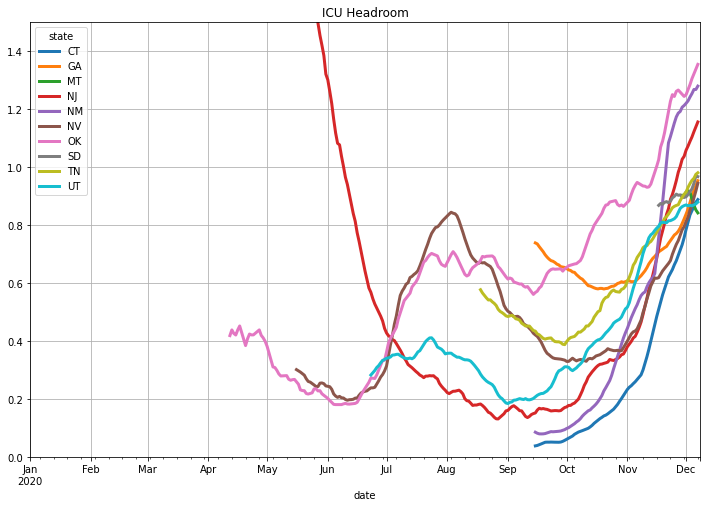

In [342]:
plot_worst_states(column='can_icu_headroom_used', 
                  title='ICU Headroom', ylim=(0, 1.5))

# ICU Headroom using HHS data.

'Worst States:'

['NM', 'ND', 'OK', 'AL', 'MO', 'TX', 'NV', 'SD', 'MN', 'MS']

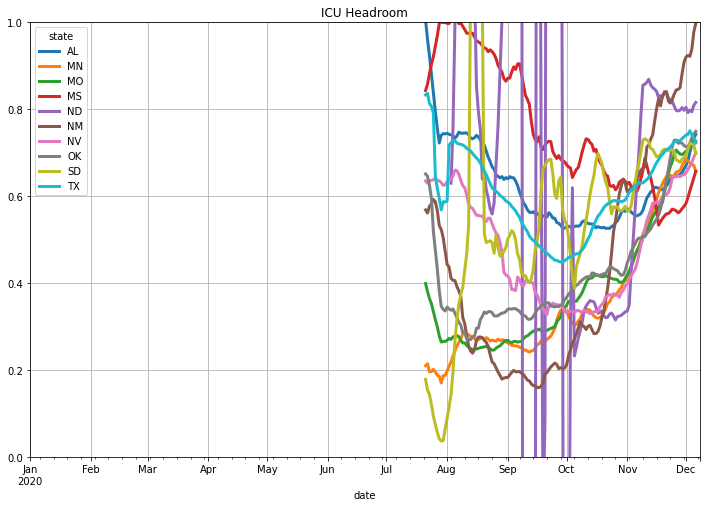

In [343]:
# NOTE: This includes suspected. We could use staffed_icu_adult_patients_confirmed_covid instead.
covid_icu_patients_column='staffed_icu_adult_patients_confirmed_and_suspected_covid';
data['hhs_icu_noncovid'] = data['staffed_adult_icu_bed_occupancy'] - data[covid_icu_patients_column];
data['hhs_icu_headroom'] = data['total_staffed_adult_icu_beds'] - data['hhs_icu_noncovid'];
data['hhs_icu_headroom_used'] = (data[covid_icu_patients_column] / data['hhs_icu_headroom']).rolling(7).mean()

plot_worst_states(column='hhs_icu_headroom_used', title='ICU Headroom', ylim=(0, 1.0))

## Arizona data comparison
[Arizona dashboard](https://www.azdhs.gov/preparedness/epidemiology-disease-control/infectious-disease-epidemiology/covid-19/dashboards/index.php)
says that on 2020-11-29 there were:

|Column|Value|
|----|---|
|non-covid patients|983|
|covid patients|579|
|total beds|1751|

The covid patients are spot on, but AZ reports an additional 261 non-covid patients than HHS, and HHS reports an additional 267 beds.

In [344]:
data.loc[('AZ', '2020-11-29')][['hhs_icu_noncovid', covid_icu_patients_column, 'total_staffed_adult_icu_beds']]

hhs_icu_noncovid                                             739
staffed_icu_adult_patients_confirmed_and_suspected_covid     587
total_staffed_adult_icu_beds                                2049
Name: (AZ, 2020-11-29 00:00:00), dtype: object

# ICU Headroom using CAN data except HHS Beds

'Worst States:'

['OK', 'NV', 'TN', 'RI', 'IN', 'UT', 'MI', 'MO', 'PA', 'AR']

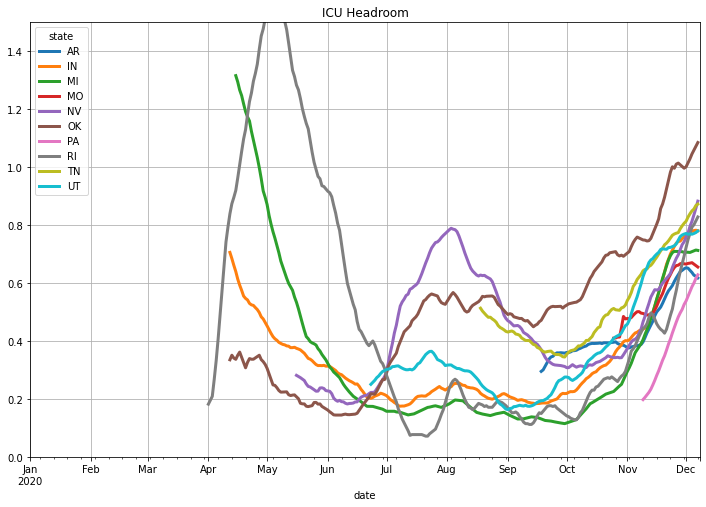

In [345]:
hhs_latest_beds = data.groupby('state').last()['total_staffed_adult_icu_beds']
data['hhs_latest_beds'] = hhs_latest_beds.reindex(data.index, level='state')

data['can_hhs_icu_noncovid_estimate'] = data['hhs_latest_beds'] * ((data['actuals.icuBeds.typicalUsageRate']-data['can_icu_decomp']).clip(0))
data['can_hhs_icu_headroom'] = data['hhs_latest_beds'] - data['can_hhs_icu_noncovid_estimate']
data['can_hhs_icu_headroom_used'] = (data['actuals.icuBeds.currentUsageCovid'] / data['can_hhs_icu_headroom']).rolling(7).mean()
plot_worst_states(column='can_hhs_icu_headroom_used', title='ICU Headroom', ylim=(0, 1.5))

# ICU Headroom using CAN data except HHS Beds and no decomp

'Worst States:'

['OK', 'TN', 'NV', 'AZ', 'MS', 'MI', 'IN', 'PA', 'MO', 'OH']

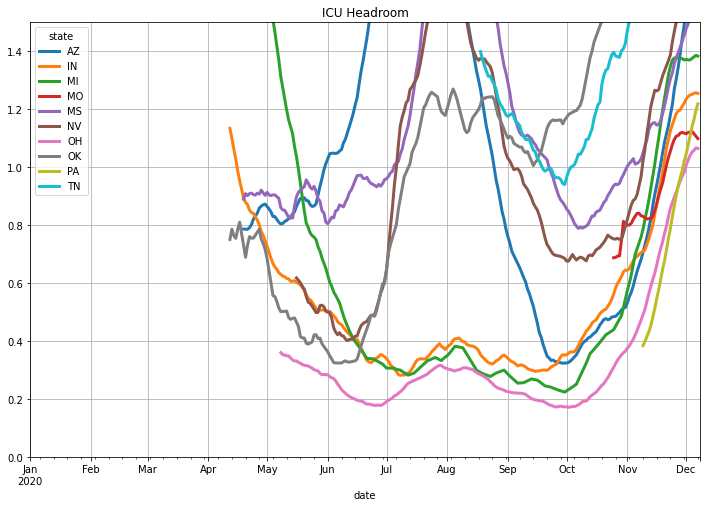

In [346]:
hhs_latest_beds = data.groupby('state').last()['total_staffed_adult_icu_beds']
data['hhs_latest_beds'] = hhs_latest_beds.reindex(data.index, level='state')

data['can_hhs_icu_noncovid_estimate'] = data['hhs_latest_beds'] * data['actuals.icuBeds.typicalUsageRate']
data['can_hhs_icu_headroom'] = data['hhs_latest_beds'] - data['can_hhs_icu_noncovid_estimate']
data['can_hhs_icu_headroom_used'] = (data['actuals.icuBeds.currentUsageCovid'] / data['can_hhs_icu_headroom']).rolling(7).mean()
plot_worst_states(column='can_hhs_icu_headroom_used', title='ICU Headroom', ylim=(0, 1.5))

# HHS ICU Beds Utilization %

'Worst States:'

['NM', 'ND', 'AL', 'OK', 'MO', 'TX', 'GA', 'RI', 'TN', 'NV']

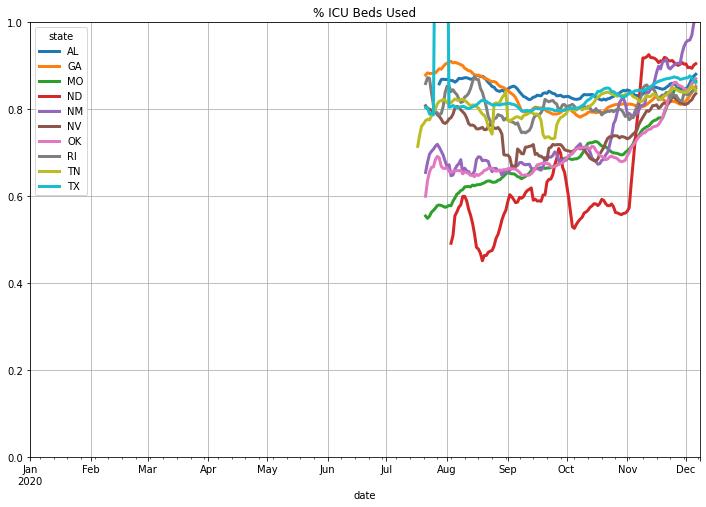

In [347]:
data['adult_icu_bed_utilization_avg'] = data['adult_icu_bed_utilization'].rolling(7).mean()
plot_worst_states(column='adult_icu_bed_utilization_avg', title='% ICU Beds Used', ylim=(0, 1))

# HHS Inpatient Beds Utilization %

'Worst States:'

['RI', 'DC', 'NV', 'MD', 'SC', 'MO', 'MI', 'GA', 'NJ', 'FL']

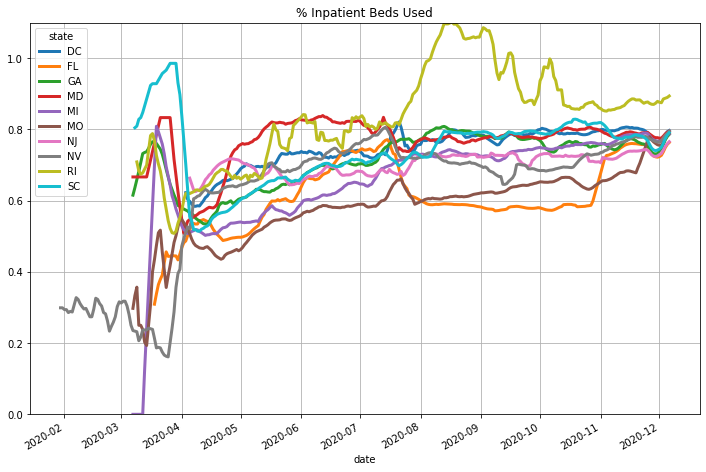

In [348]:
data['inpatient_beds_utilization_avg'] = data['inpatient_beds_utilization'].rolling(7).mean()
plot_worst_states(column='inpatient_beds_utilization_avg', title='% Inpatient Beds Used', ylim=(0, 1.1))

# COVID Hospitalizations per 100k (HHS)

'Worst States:'

['SD', 'NV', 'ND', 'IN', 'PA', 'OH', 'NE', 'IL', 'MO', 'MI']

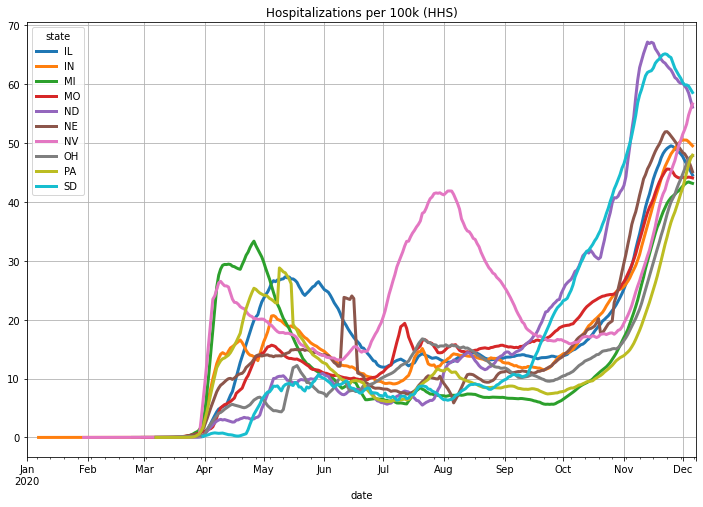

In [349]:
data['inpatient_beds_used_covid_per_100k'] = (data['inpatient_beds_used_covid'] / (data['population'] / 100000)).rolling(7).mean()
plot_worst_states(column='inpatient_beds_used_covid_per_100k', title='Hospitalizations per 100k (HHS)')

# COVID Hospitalizations per 100k (CAN)

'Worst States:'

['SD', 'NV', 'IN', 'MT', 'NM', 'OH', 'MO', 'OK', 'IL', 'NE']

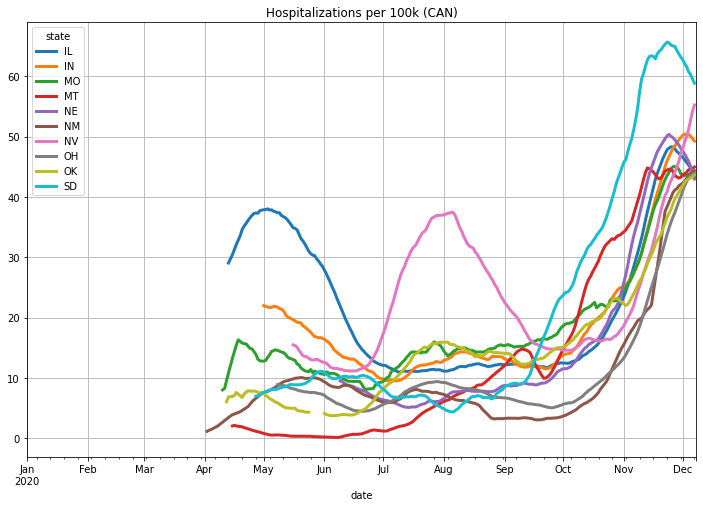

In [350]:
data['can_inpatient_beds_used_covid_per_100k'] = (data['actuals.hospitalBeds.currentUsageCovid'] / (data['population'] / 100000)).rolling(7).mean()
plot_worst_states(column='can_inpatient_beds_used_covid_per_100k', title='Hospitalizations per 100k (CAN)')

# Calculate % Critical Staffing shortage (via HHS data)

In [351]:
# Calculate % of states reporting, and drop states with <50% reporting in the last week.
#data['critical_staffing_shortage_report_%'] = 1 - data['critical_staffing_shortage_today_not_reported']/(data['critical_staffing_shortage_today_not_reported']+data['critical_staffing_shortage_today_yes']+data['critical_staffing_shortage_today_no'])
#data = data.groupby('state').filter(lambda x: x.tail(7)['critical_staffing_shortage_report_%'].mean() > 0.5)

In [352]:
# Calculate critical_shortage_%
critical_shortage_pct=data['critical_staffing_shortage_today_yes']/(data['critical_staffing_shortage_today_yes']+data['critical_staffing_shortage_today_no'])
critical_shortage_pct=critical_shortage_pct.reset_index('state').groupby('state').rolling(7).mean().reset_index().set_index(['state', 'date'])
data['critical_staffing_shortage_%'] = critical_shortage_pct

'Worst States:'

['PR', 'VI', 'ND', 'MO', 'NM', 'WI', 'AR', 'OK', 'WV', 'KS']

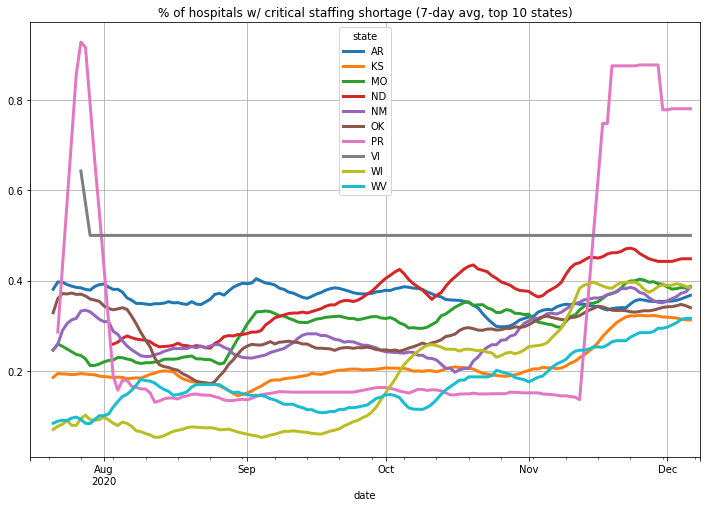

In [353]:
plot_worst_states(column='critical_staffing_shortage_%', 
                  title='% of hospitals w/ critical staffing shortage (7-day avg, top 10 states)', 
                  start_date='2020-07-15')

# US ICU Beds, ICU Patients, and Utilization

<AxesSubplot:xlabel='date'>

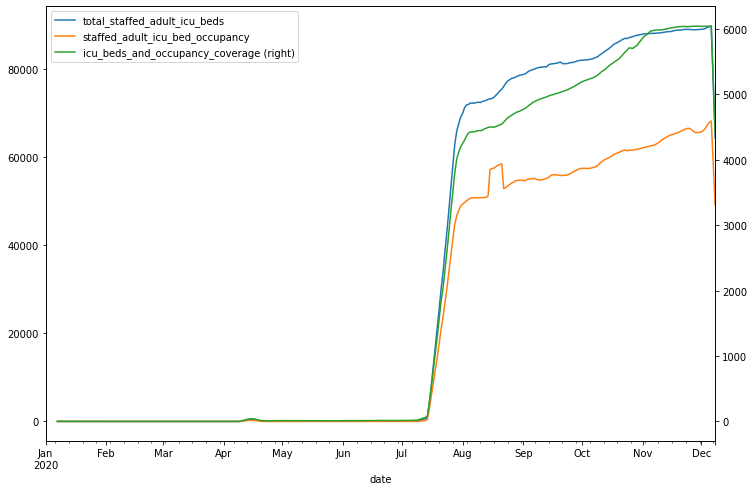

In [354]:
usa_data = data.groupby('date').sum()
usa_data['icu_beds_and_occupancy_coverage'] = (usa_data['total_staffed_adult_icu_beds_coverage']+usa_data['staffed_adult_icu_bed_occupancy_coverage'])/2
usa_data[['total_staffed_adult_icu_beds', 'staffed_adult_icu_bed_occupancy', 'icu_beds_and_occupancy_coverage']].rolling(7).mean().plot(figsize=(12, 8), secondary_y=['icu_beds_and_occupancy_coverage'])

<AxesSubplot:xlabel='date'>

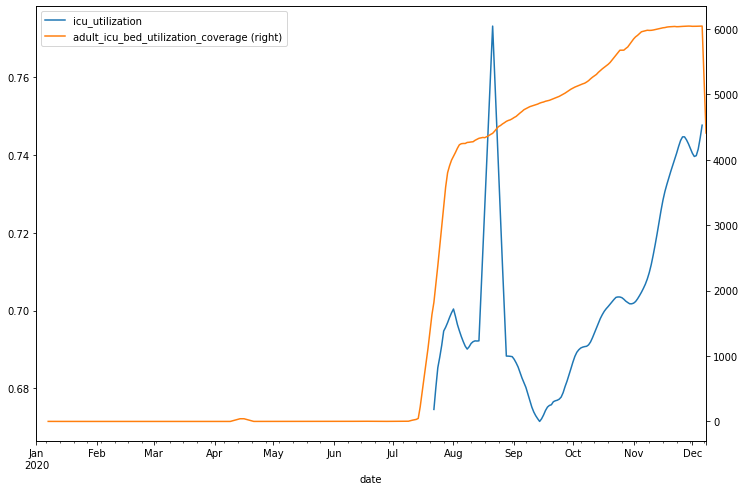

In [355]:
usa_data['icu_utilization'] = (usa_data['adult_icu_bed_utilization_numerator'] / usa_data['adult_icu_bed_utilization_denominator']).rolling(7).mean();
usa_data[['icu_utilization', 'adult_icu_bed_utilization_coverage']].rolling(7).mean().plot(secondary_y=['adult_icu_bed_utilization_coverage'], figsize=(12, 8))

# HHS Beds vs CCM Beds

Text(5500, 500, 'CAN has more beds')

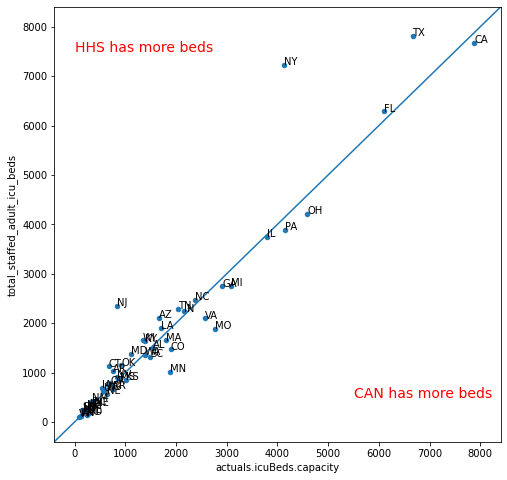

In [356]:
fig, ax = plt.subplots()
state_last_beds = data.groupby('state').last()[['actuals.icuBeds.capacity','total_staffed_adult_icu_beds']]
state_last_beds.plot.scatter(x='actuals.icuBeds.capacity', y='total_staffed_adult_icu_beds', ax=ax, figsize=(8, 8))

for k, v in state_last_beds.iterrows():
    ax.annotate(k, v)

ax.axline((0,0), (8000, 8000))
ax.text(0, 7500, 'HHS has more beds', fontsize=14, color='red')
ax.text(5500, 500, 'CAN has more beds', fontsize=14, color='red')

# CAN decomp vs HHS decomp

Text(0.2, -0.2, 'CAN decomp is too high')

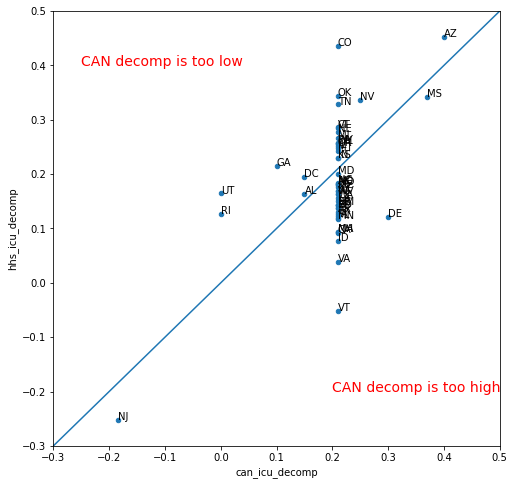

In [357]:
data['hhs_icu_decomp']=data['actuals.icuBeds.typicalUsageRate'] - (data['staffed_adult_icu_bed_occupancy'] - data['staffed_icu_adult_patients_confirmed_and_suspected_covid'])/data['total_staffed_adult_icu_beds']

fig, ax = plt.subplots()
state_last_decomp = data[['can_icu_decomp', 'hhs_icu_decomp']].rolling(7).mean().groupby('state').last()
state_last_decomp.plot.scatter(x='can_icu_decomp', y='hhs_icu_decomp', ax=ax, figsize=(8, 8), ylim=(-0.3, 0.5), xlim=(-0.3, 0.5))

for k, v in state_last_decomp.iterrows():
    ax.annotate(k, v)

ax.axline((-0.3,-0.3), (0.5, 0.5))
ax.text(-0.25, 0.4, 'CAN decomp is too low', fontsize=14, color='red')
ax.text(0.2, -0.2, 'CAN decomp is too high', fontsize=14, color='red')

# ICU Beds vs Inpatient Beds Fullness

Text(0.85, 0.52, 'Inpatient beds are more full')

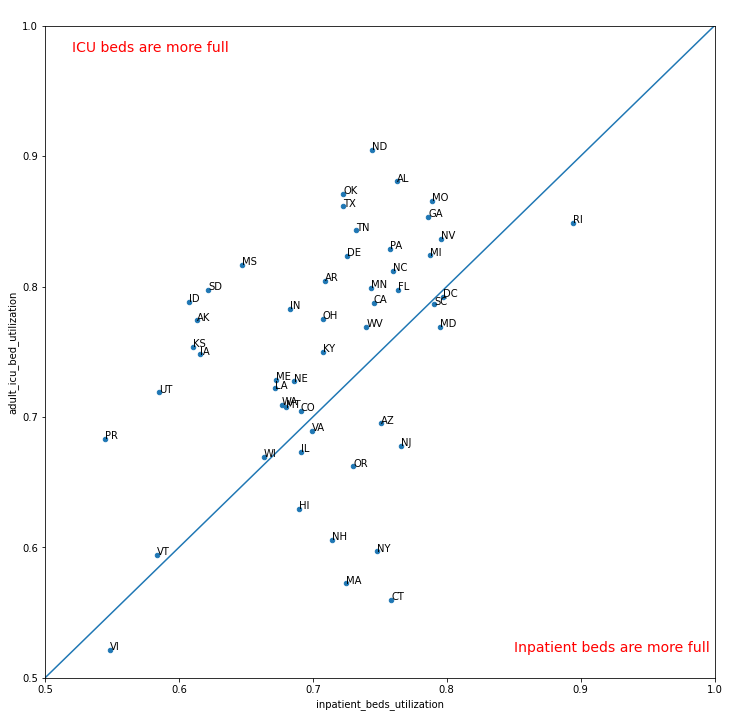

In [358]:
fig, ax = plt.subplots()
state_utilization = data[['inpatient_beds_utilization','adult_icu_bed_utilization']].rolling(7).mean().groupby('state').last()
state_utilization.plot.scatter(x='inpatient_beds_utilization', y='adult_icu_bed_utilization', ax=ax, figsize=(12, 12), xlim=(0.5, 1), ylim=(0.5, 1))

for k, v in state_utilization.iterrows():
    ax.annotate(k, v)

ax.axline((0.5,0.5), (1, 1))
ax.text(0.52, 0.98, 'ICU beds are more full', fontsize=14, color='red')
ax.text(0.85, 0.52, 'Inpatient beds are more full', fontsize=14, color='red')

# Whitehouse Metric

In [359]:
# TODO: I'm including confirmed _and_ suspected, which seems to be relatively close to the WH reports, though ND is closer without suspected. :-/
data['weekly_covid_admissions'] = (data['previous_day_admission_adult_covid_confirmed'] + data['previous_day_admission_adult_covid_suspected']).rolling(7).sum()
data['100_beds_7_day_avg'] = data['inpatient_beds'].rolling(7).mean()/100
data['wh_metric'] = data['weekly_covid_admissions']/(data['100_beds_7_day_avg'])
    

'Worst States:'

['MD', 'AR', 'OK', 'KY', 'PA', 'NM', 'WI', 'IL', 'OH', 'IN']

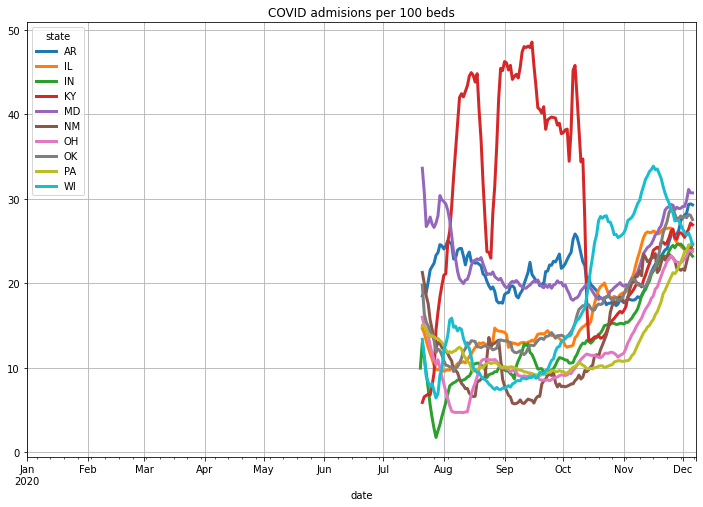

In [360]:
plot_worst_states('wh_metric', 'COVID admisions per 100 beds')

# Metric Chart Helpers

<AxesSubplot:title={'center':'Weekly COVID Admissions per 100 beds'}, xlabel='date'>

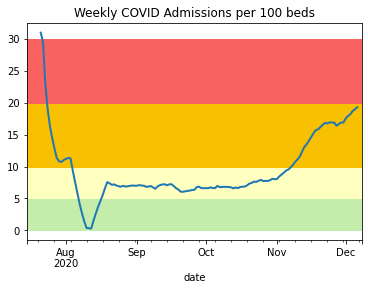

In [361]:
def wh_metric_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['wh_metric'].plot(title='Weekly COVID Admissions per 100 beds', ax=ax, lw=2, xlim=('2020-07-15',None))

    ax.axhspan(ymin=0, ymax=5, color=GREEN)
    ax.axhspan(ymin=5, ymax=10, color=YELLOW)
    ax.axhspan(ymin=10, ymax=20, color=ORANGE)
    ax.axhspan(ymin=20, ymax=30, color=RED)
    return ax

wh_metric_chart('NJ')

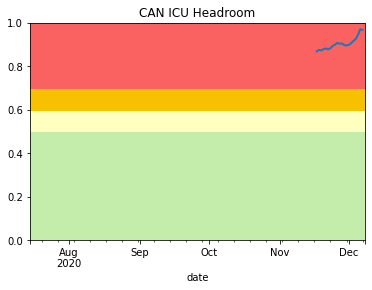

In [362]:
def can_icu_headroom_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['can_icu_headroom_used'].plot(title='CAN ICU Headroom', ax=ax, lw=2, xlim=('2020-07-15', None), ylim=(0, 1))

    ax.axhspan(ymin=0, ymax=.5, color=GREEN)
    ax.axhspan(ymin=.5, ymax=.6, color=YELLOW)
    ax.axhspan(ymin=.6, ymax=.7, color=ORANGE)
    ax.axhspan(ymin=.7, ymax=1, color=RED)

can_icu_headroom_chart('SD')


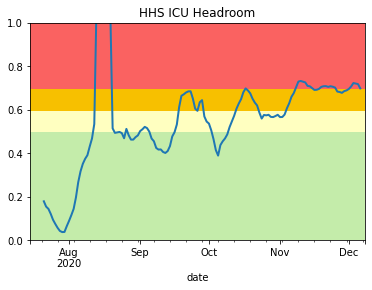

In [363]:
def hhs_icu_headroom_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['hhs_icu_headroom_used'].plot(title='HHS ICU Headroom', ax=ax, lw=2, ylim=(0, 1), xlim=('2020-07-15',None))

    ax.axhspan(ymin=0, ymax=.5, color=GREEN)
    ax.axhspan(ymin=.5, ymax=.6, color=YELLOW)
    ax.axhspan(ymin=.6, ymax=.7, color=ORANGE)
    ax.axhspan(ymin=.7, ymax=1, color=RED)

hhs_icu_headroom_chart('SD')

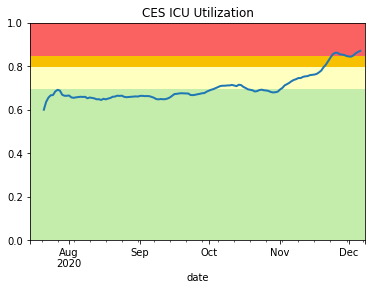

In [364]:
def ces_icu_utilization_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['adult_icu_bed_utilization'].rolling(7).mean().plot(title='CES ICU Utilization', ax=ax, lw=2, ylim=(0, 1), xlim=('2020-07-15',None))

    ax.axhspan(ymin=0, ymax=.7, color=GREEN)
    ax.axhspan(ymin=.7, ymax=.8, color=YELLOW)
    ax.axhspan(ymin=.8, ymax=.85, color=ORANGE)
    ax.axhspan(ymin=.85, ymax=1, color=RED)

ces_icu_utilization_chart('OK')

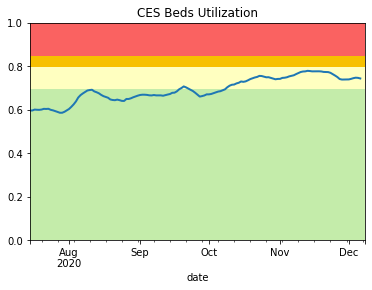

In [365]:
def ces_bed_utilization_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['inpatient_beds_utilization'].rolling(7).mean().plot(title='CES Beds Utilization', ax=ax, lw=2, ylim=(0, 1), xlim=('2020-07-15',None))

    ax.axhspan(ymin=0, ymax=.7, color=GREEN)
    ax.axhspan(ymin=.7, ymax=.8, color=YELLOW)
    ax.axhspan(ymin=.8, ymax=.85, color=ORANGE)
    ax.axhspan(ymin=.85, ymax=1, color=RED)

ces_bed_utilization_chart('ND')

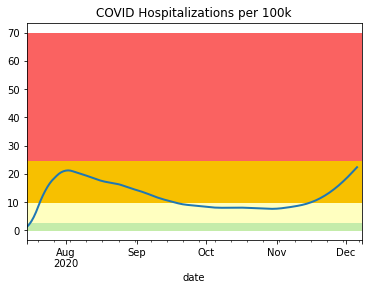

In [366]:
data['covid_hospitalizations_per_100k'] = data['total_adult_patients_hospitalized_confirmed_and_suspected_covid'].rolling(7).mean() / (data['population']/100000)

def covid_hospitalizations_per_100k_chart(state, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    data.loc[state]['covid_hospitalizations_per_100k'].rolling(7).mean().plot(title='COVID Hospitalizations per 100k', ax=ax, lw=2, xlim=('2020-07-15',None))

    ax.axhspan(ymin=0, ymax=3, color=GREEN)
    ax.axhspan(ymin=3, ymax=10, color=YELLOW)
    ax.axhspan(ymin=10, ymax=25, color=ORANGE)
    ax.axhspan(ymin=25, ymax=70, color=RED)

covid_hospitalizations_per_100k_chart('CA')

# Metric Charts for all States

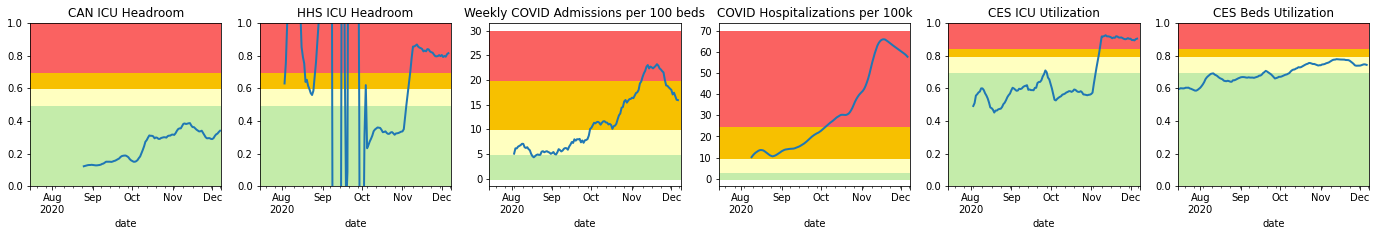

In [367]:
def show_state_charts(state):
    display(HTML('<h2>' + us.states.lookup(state).name + '</h2>'))
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(24,3))
    can_icu_headroom_chart(state, axes[0])
    hhs_icu_headroom_chart(state, axes[1])
    wh_metric_chart(state, axes[2])
    covid_hospitalizations_per_100k_chart(state, axes[3])
    ces_icu_utilization_chart(state, axes[4])
    ces_bed_utilization_chart(state, axes[5])
    display(fig)
    plt.close()
    
show_state_charts('ND')

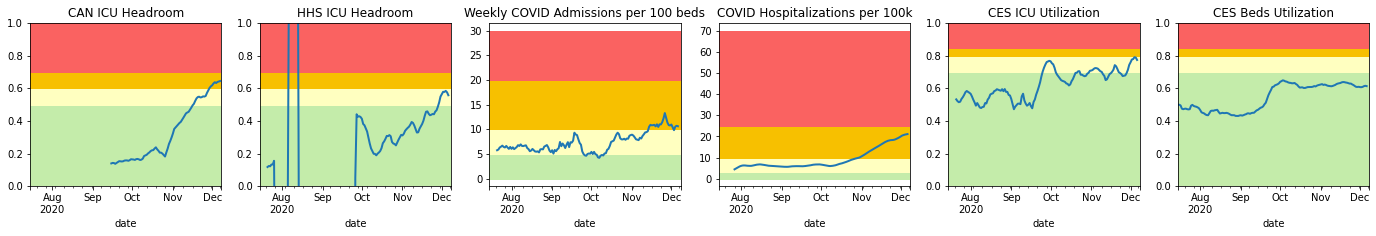

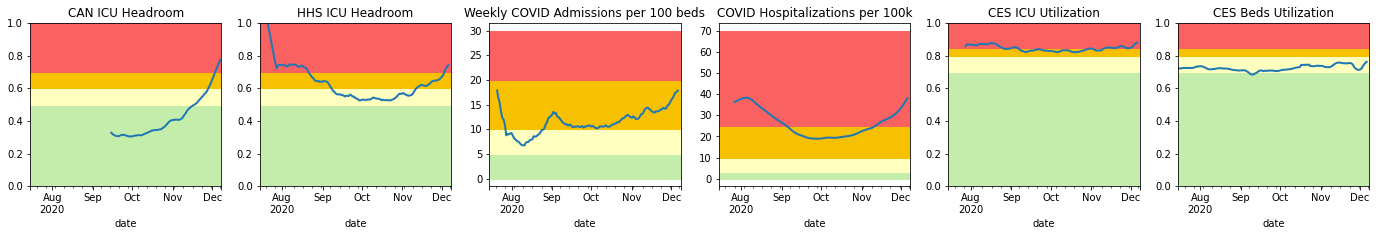

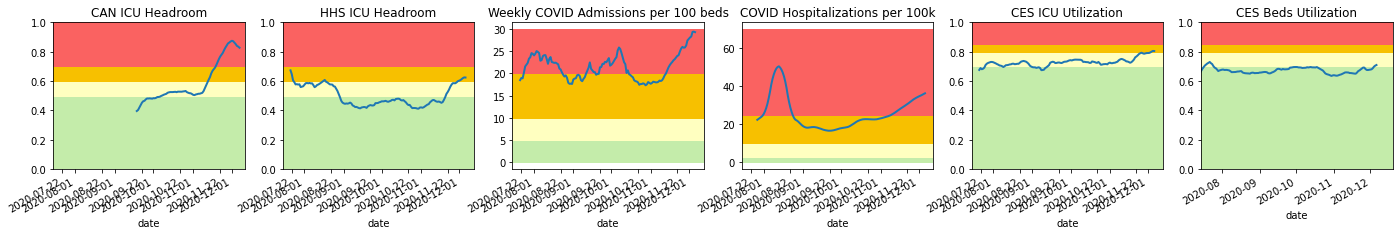

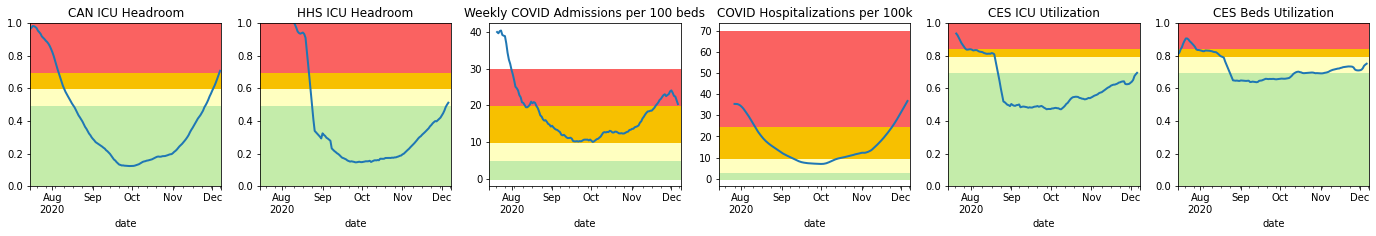

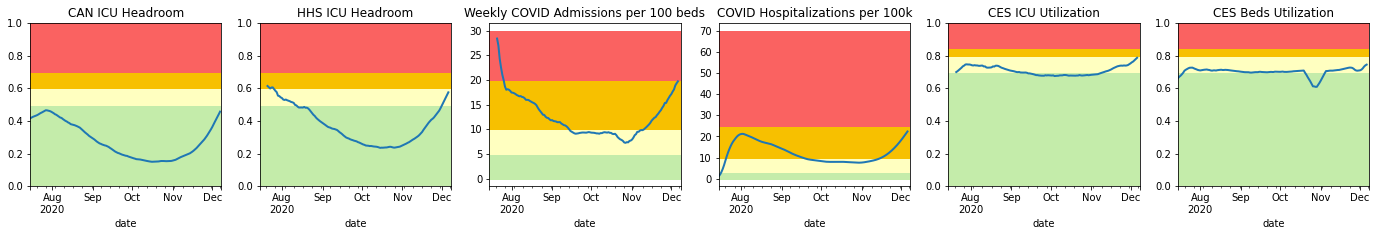

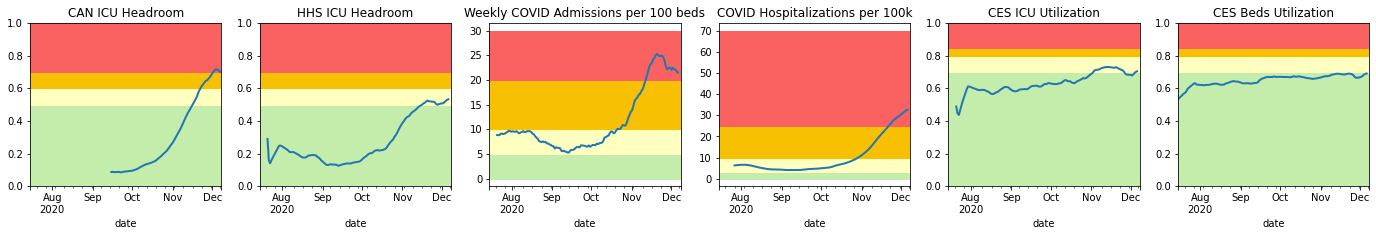

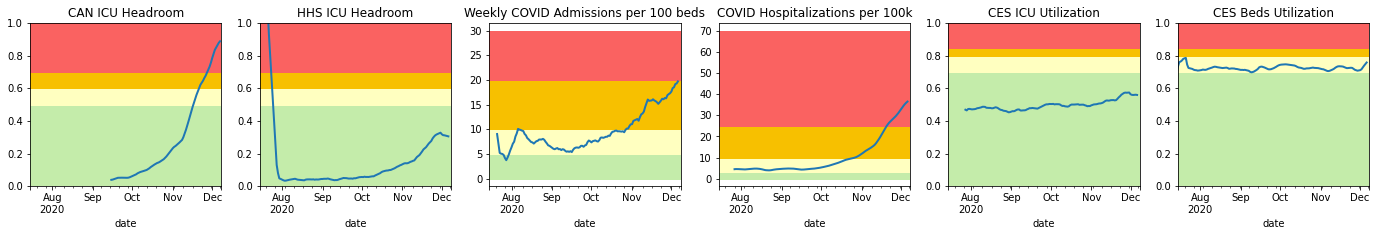

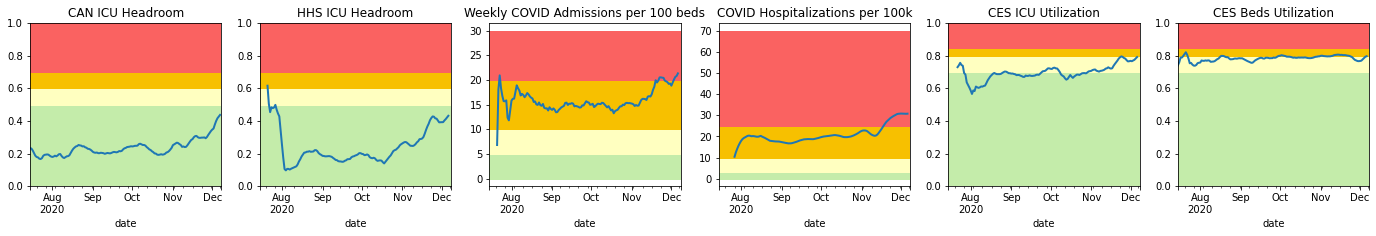

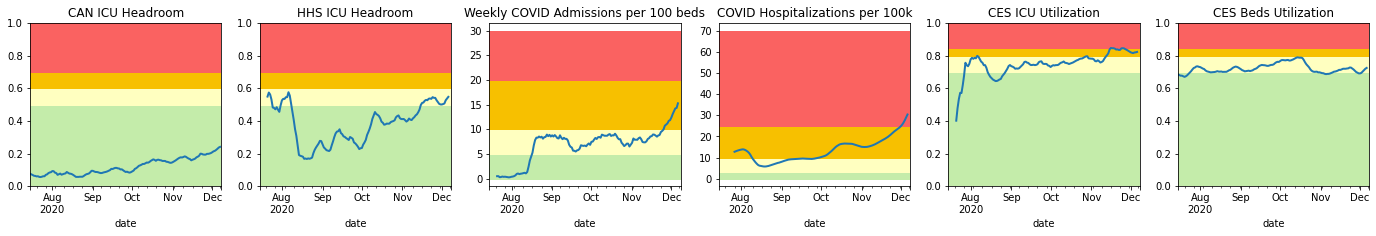

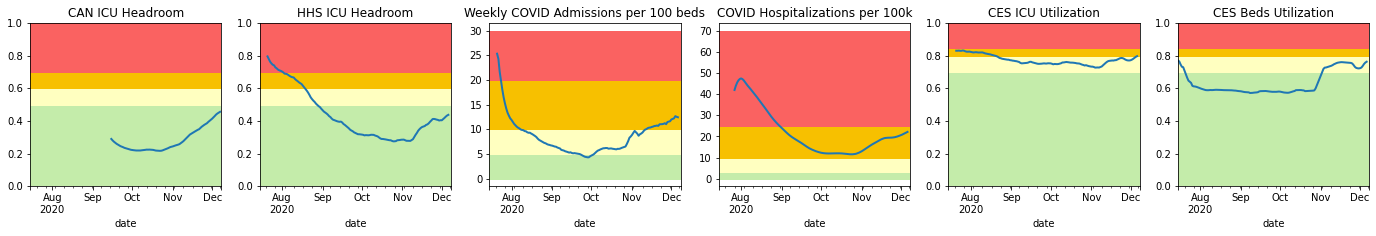

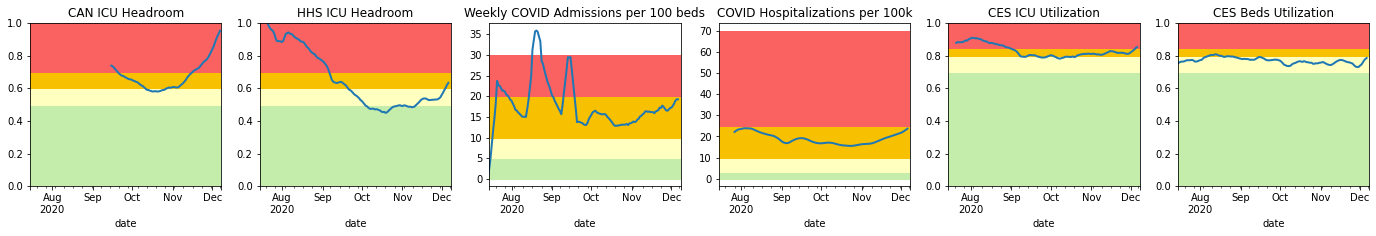

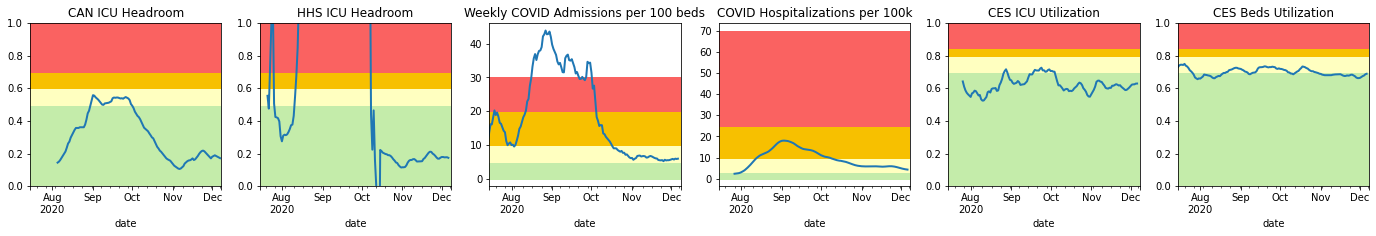

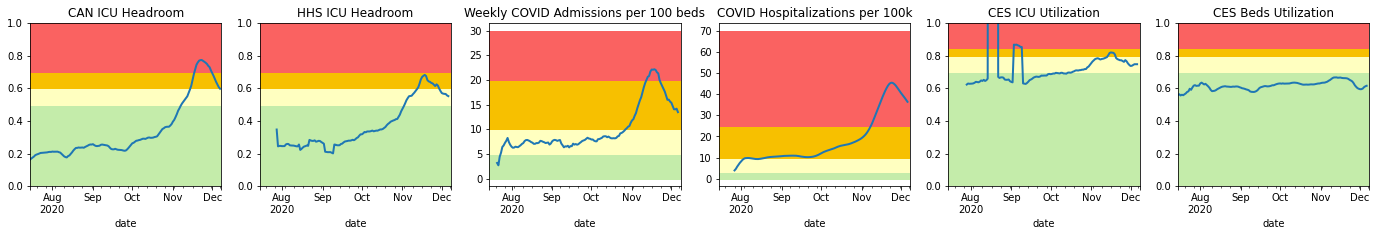

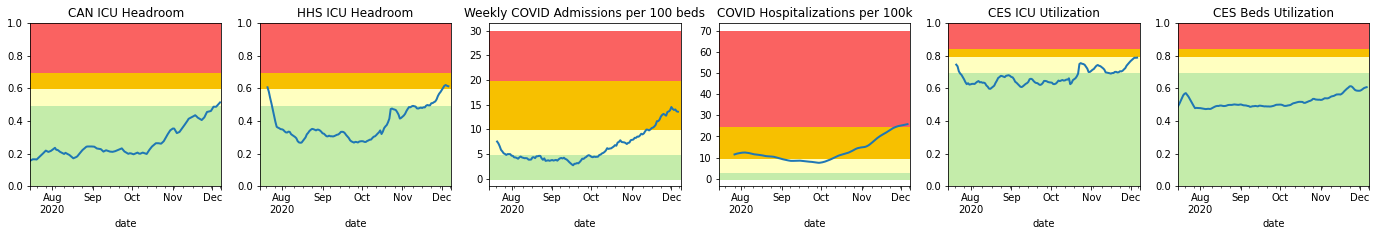

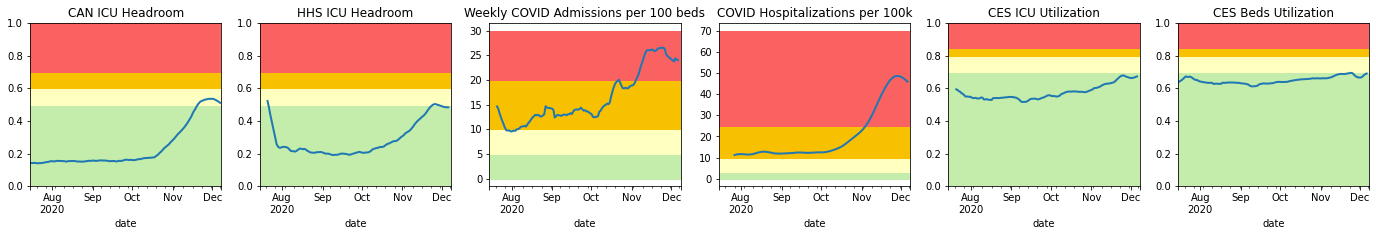

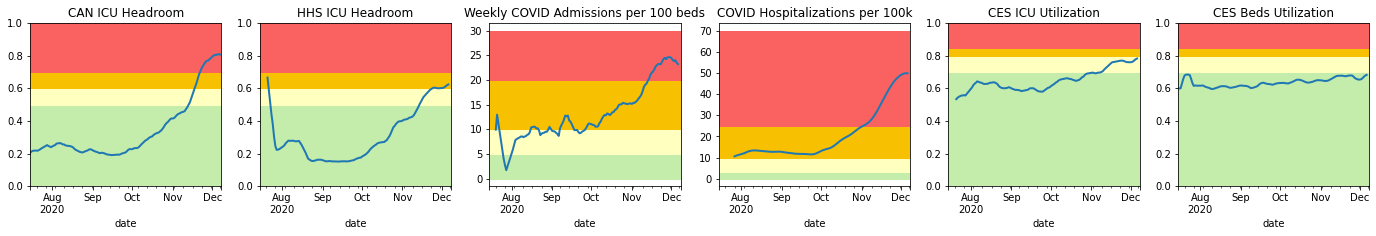

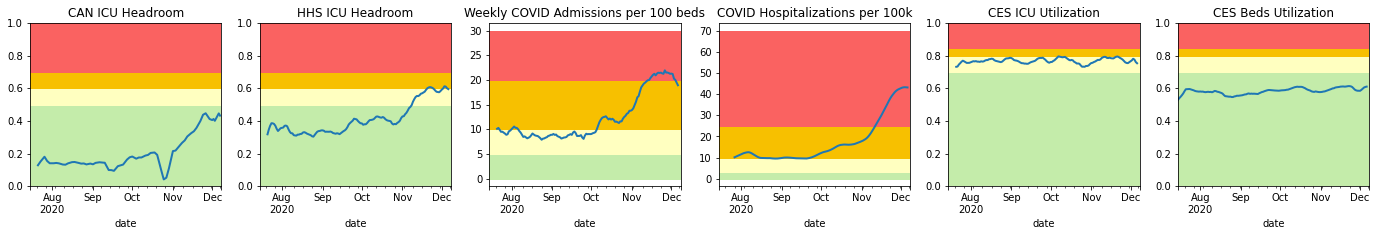

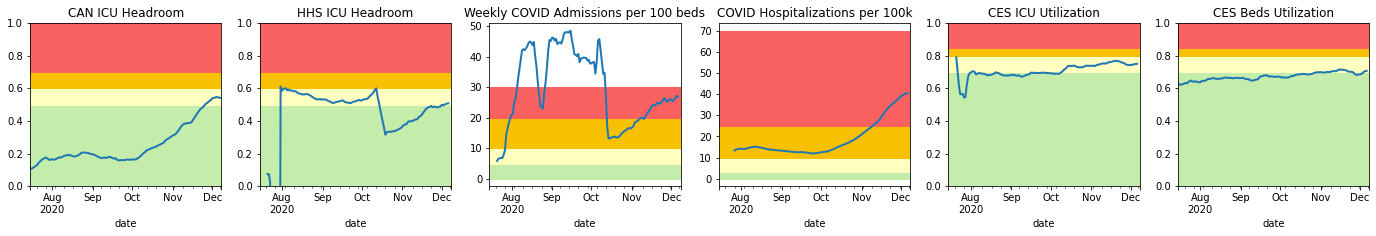

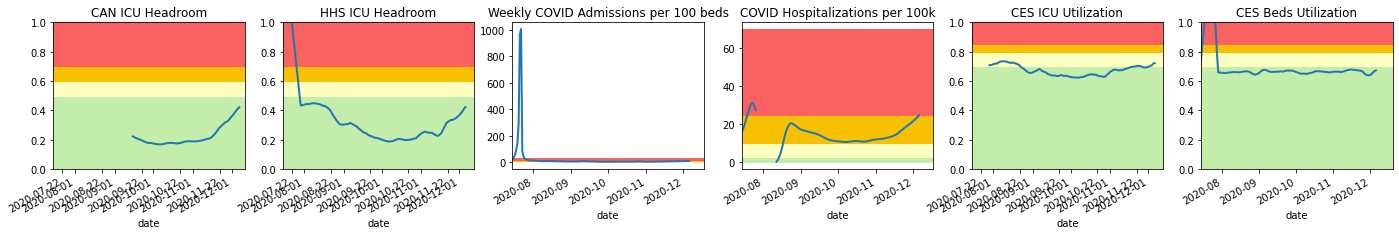

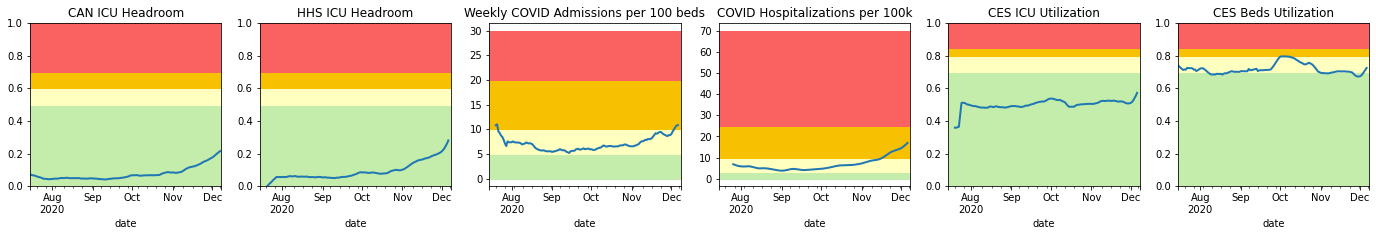

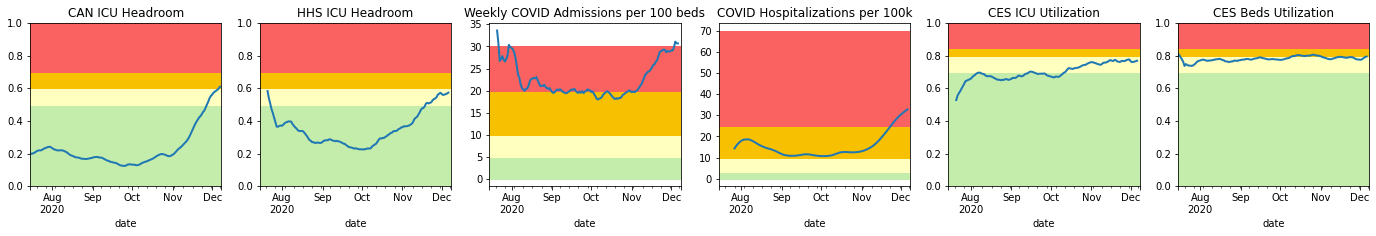

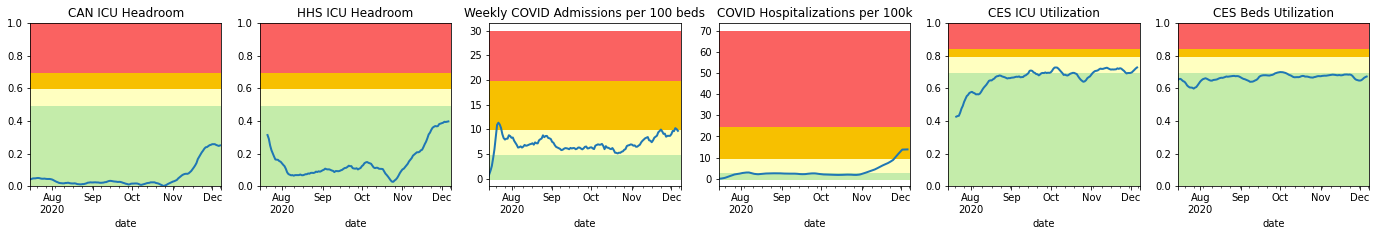

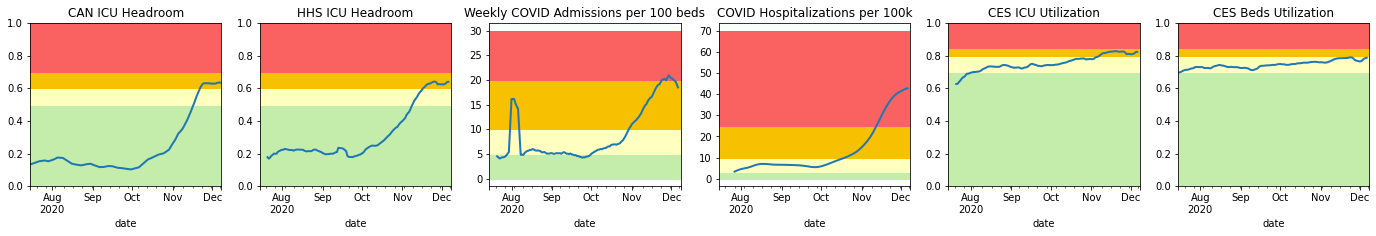

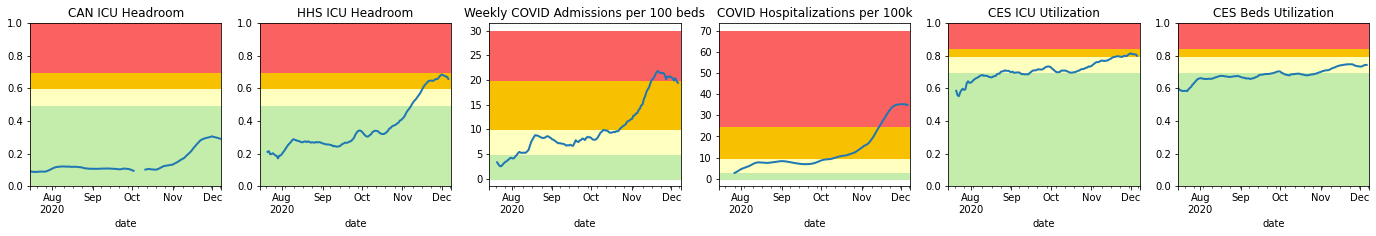

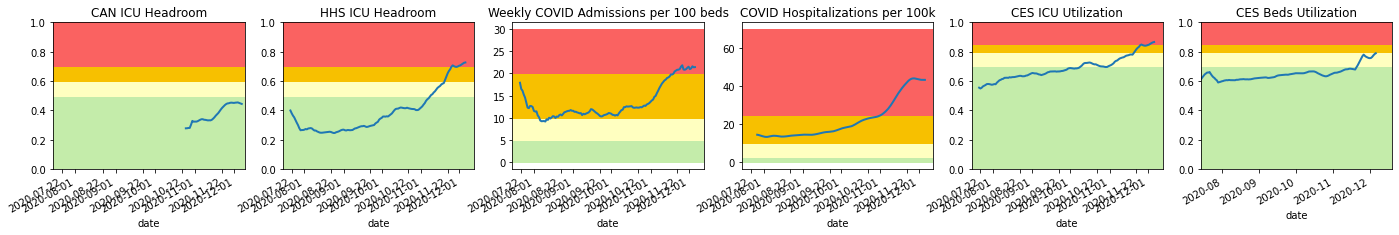

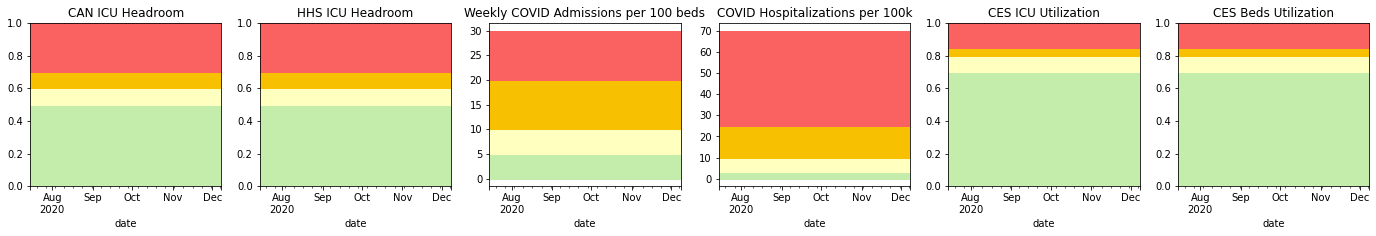

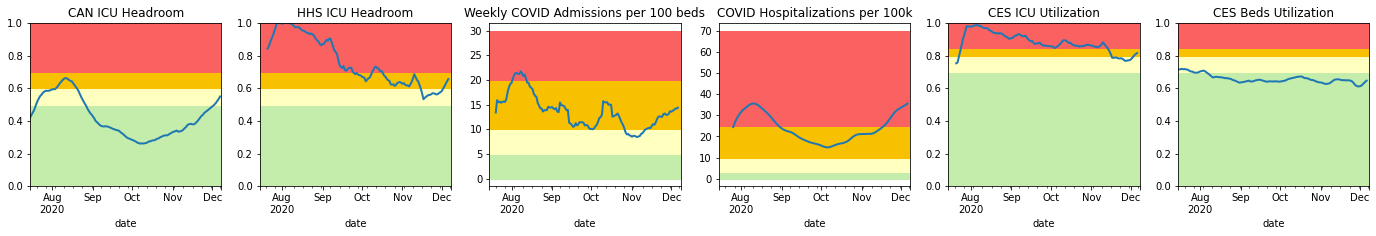

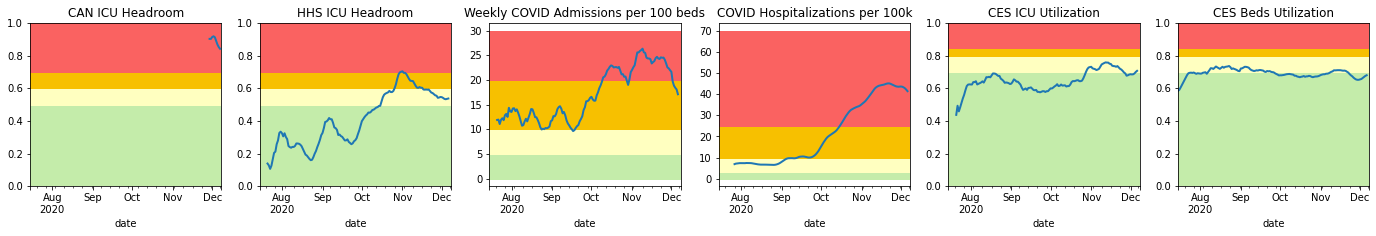

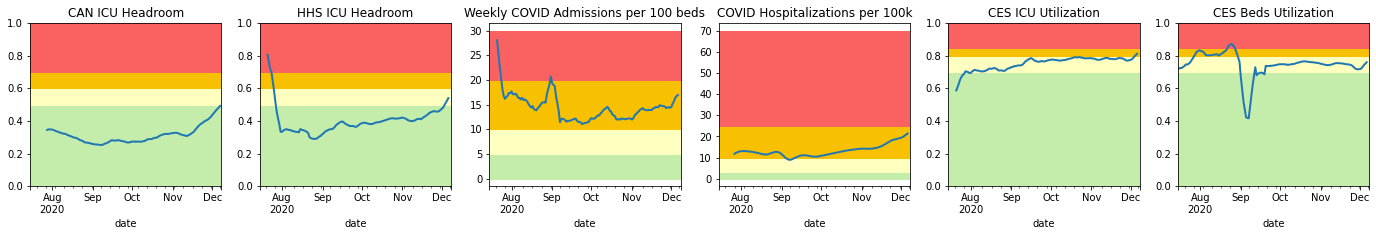

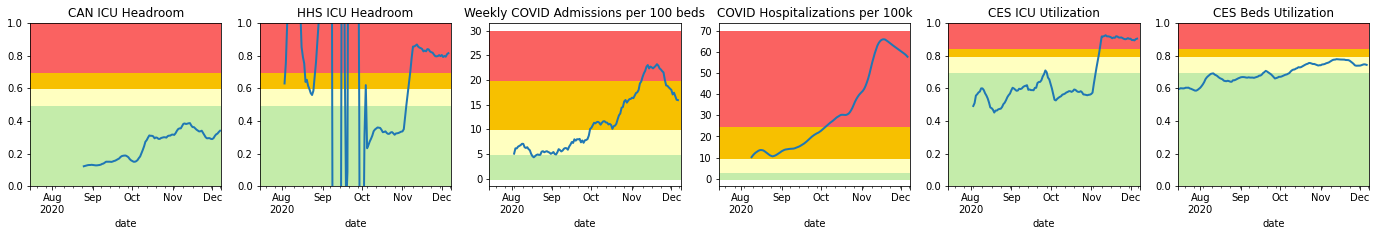

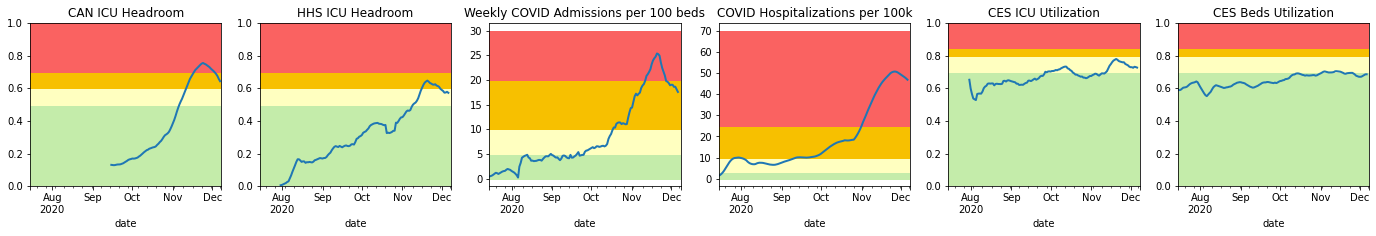

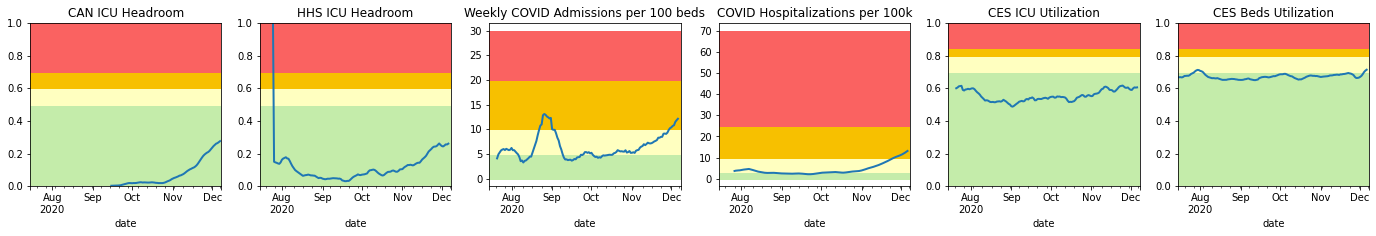

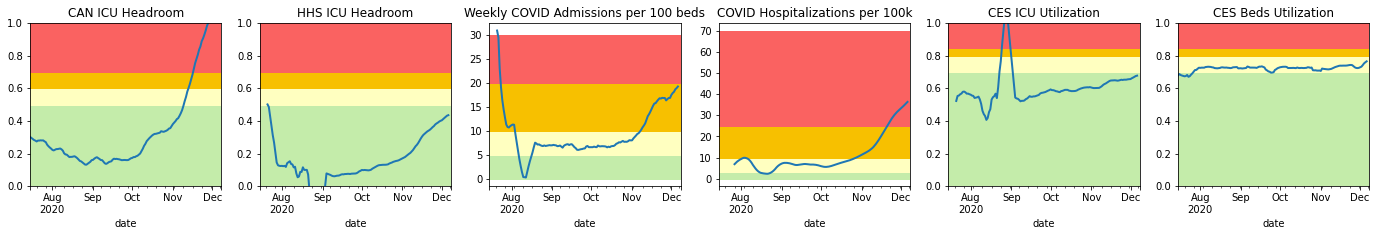

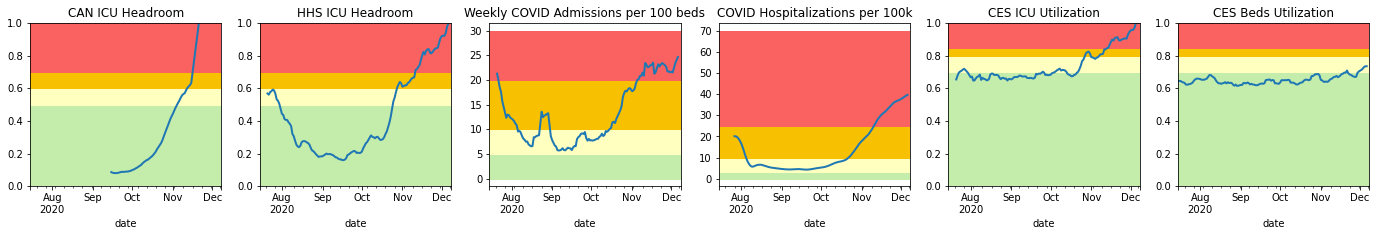

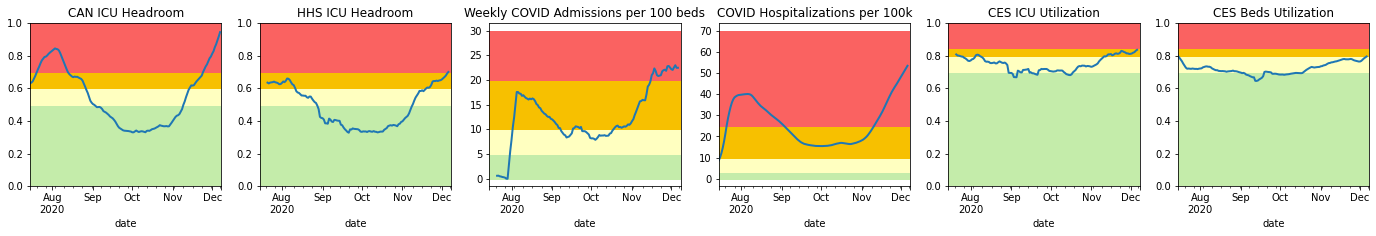

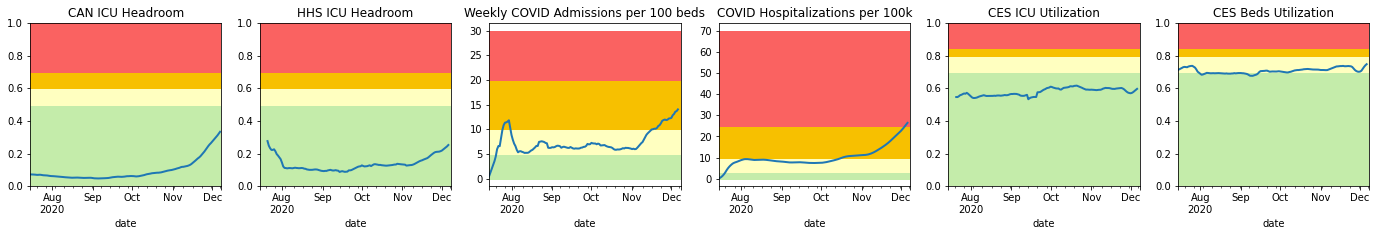

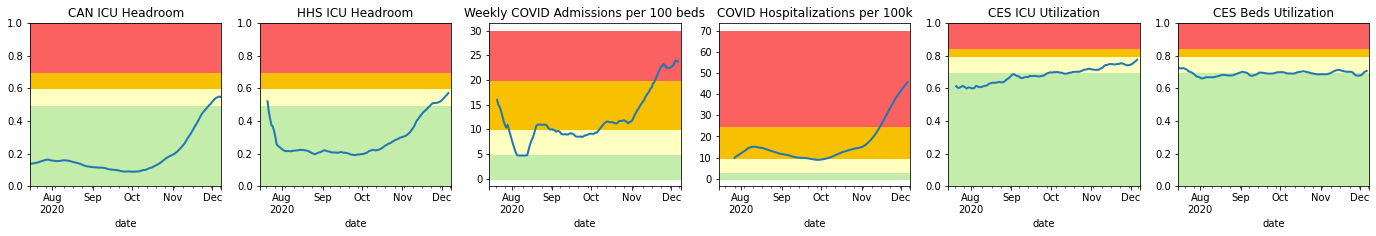

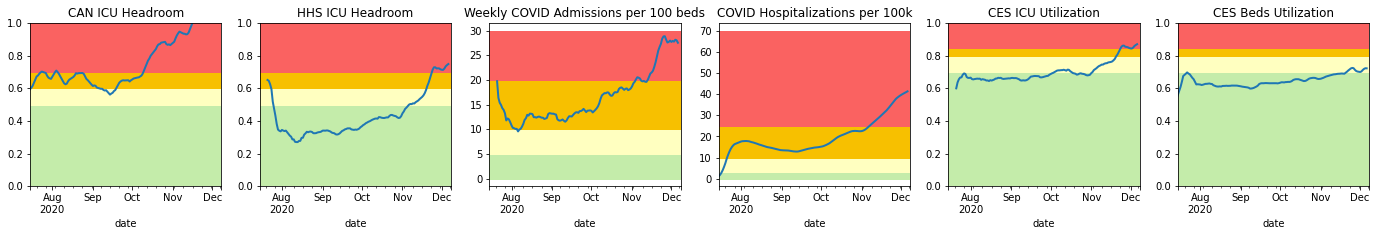

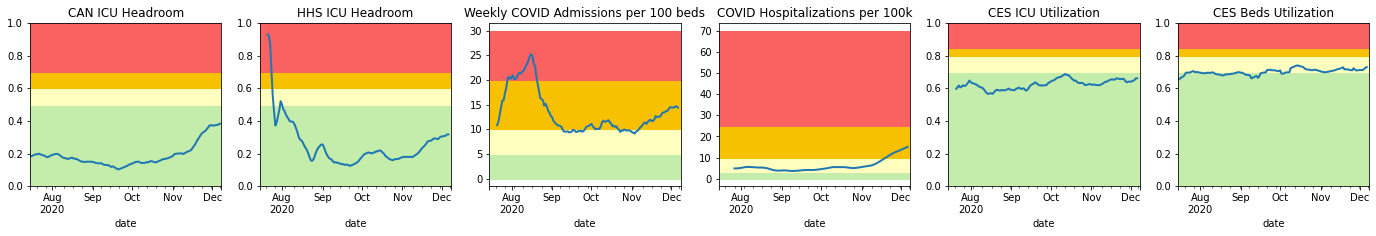

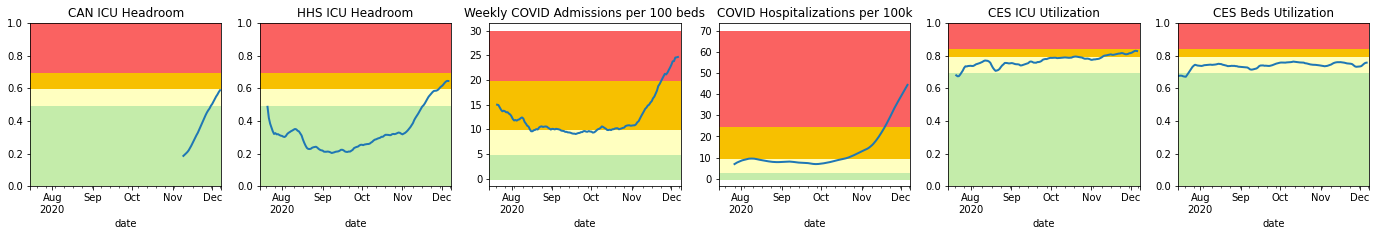

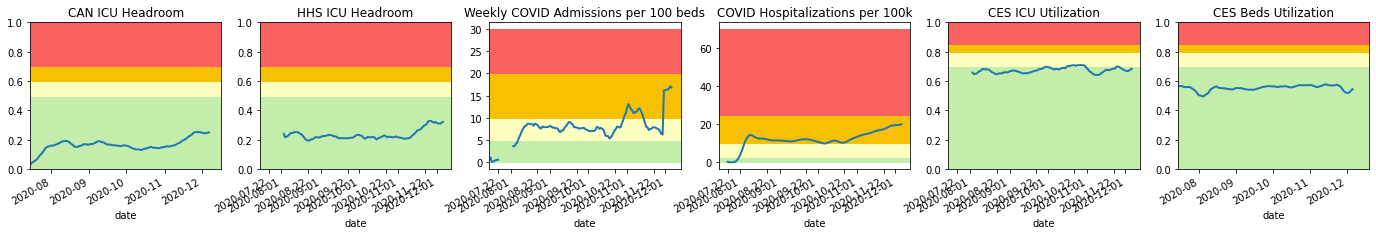

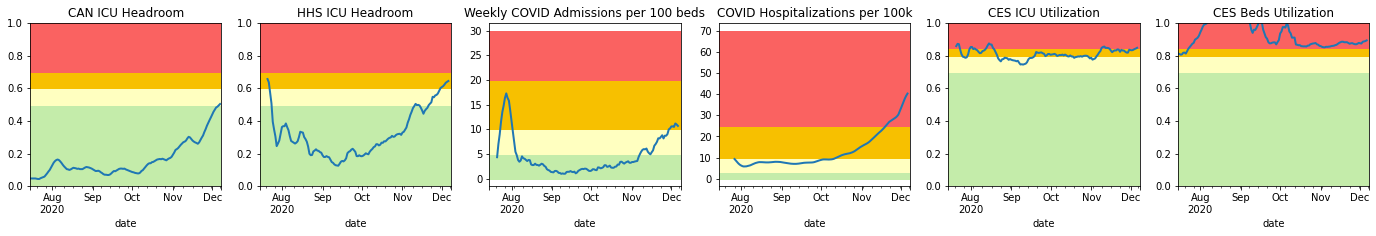

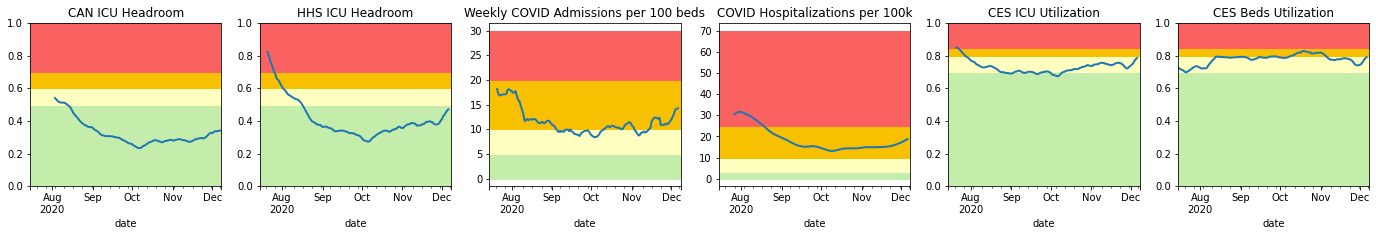

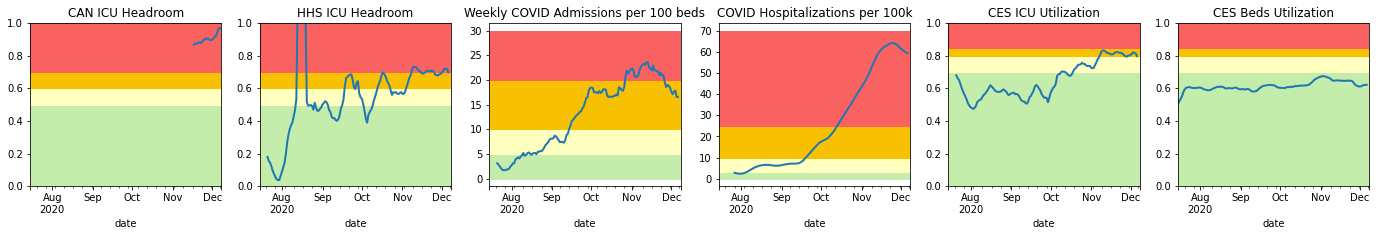

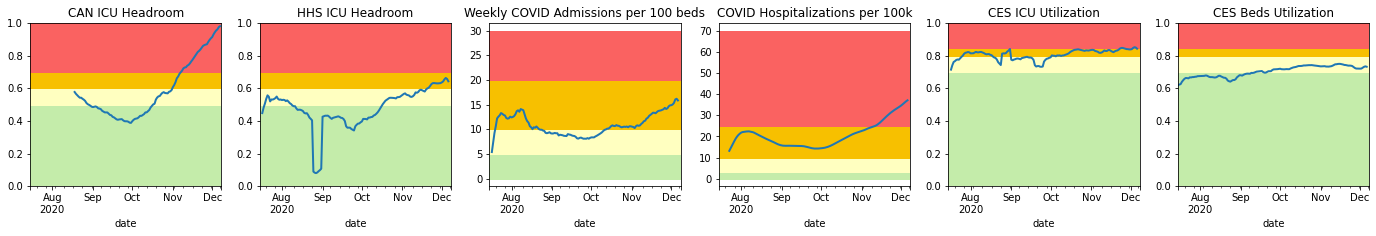

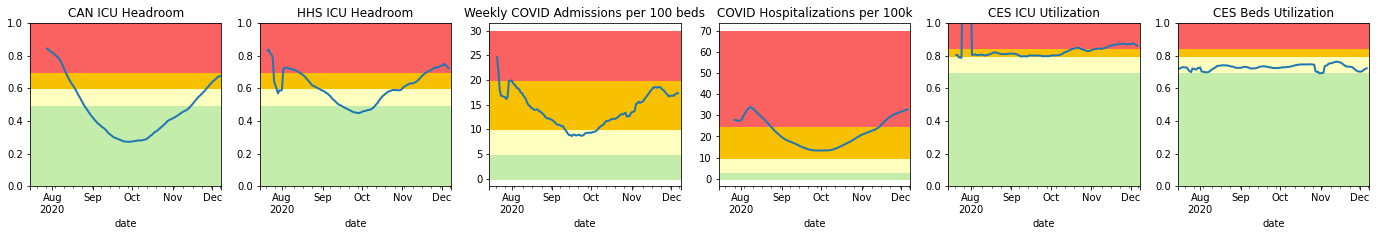

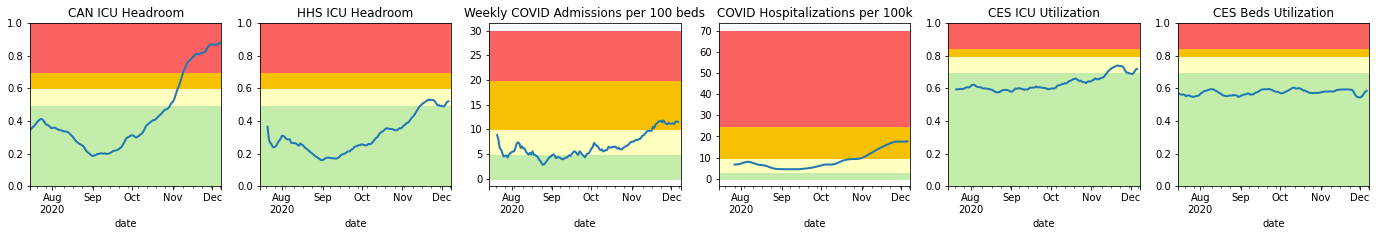

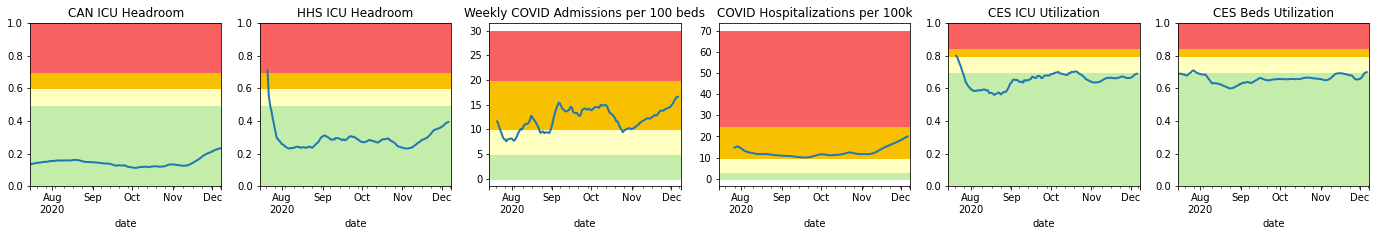

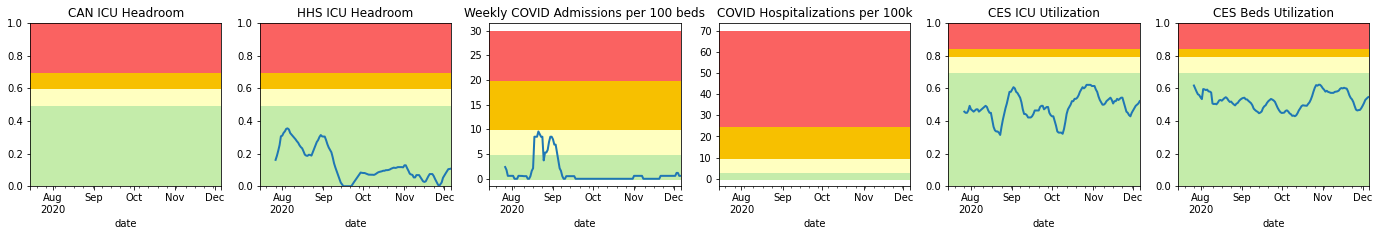

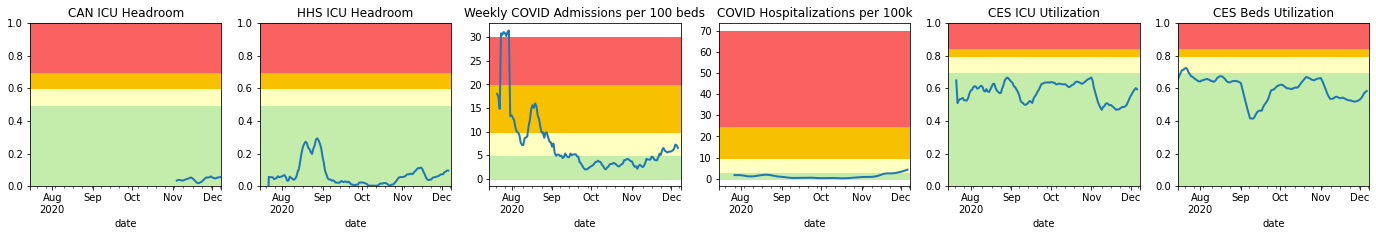

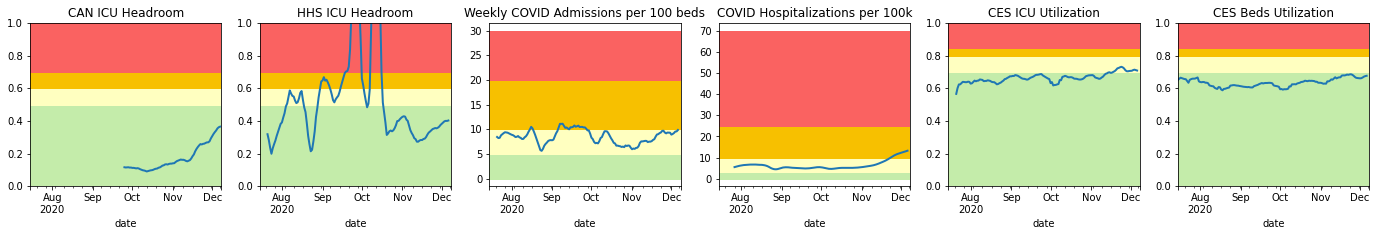

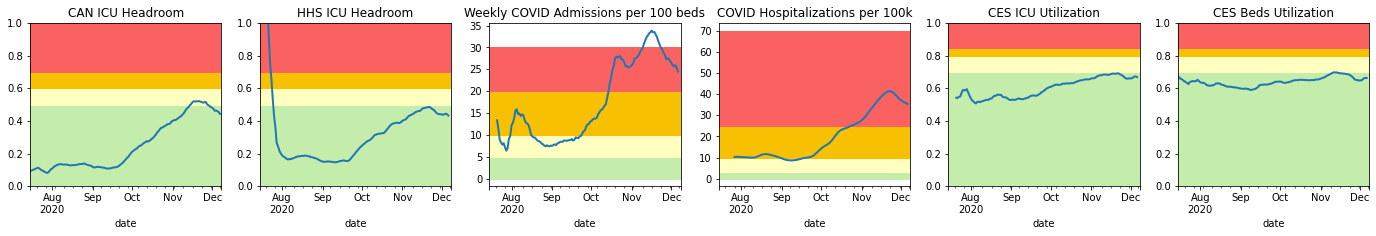

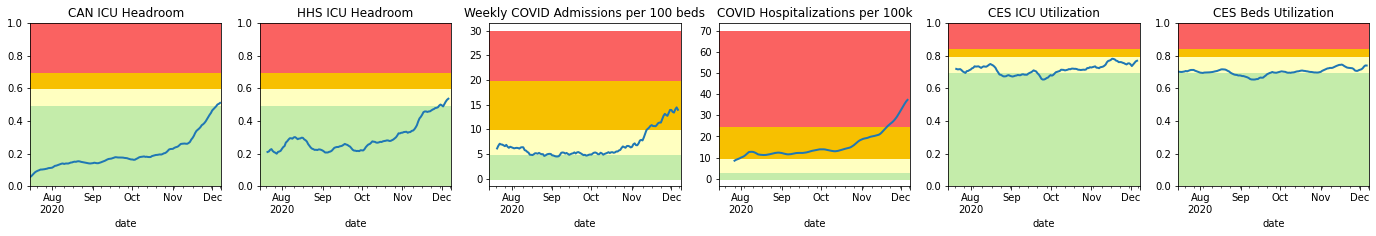

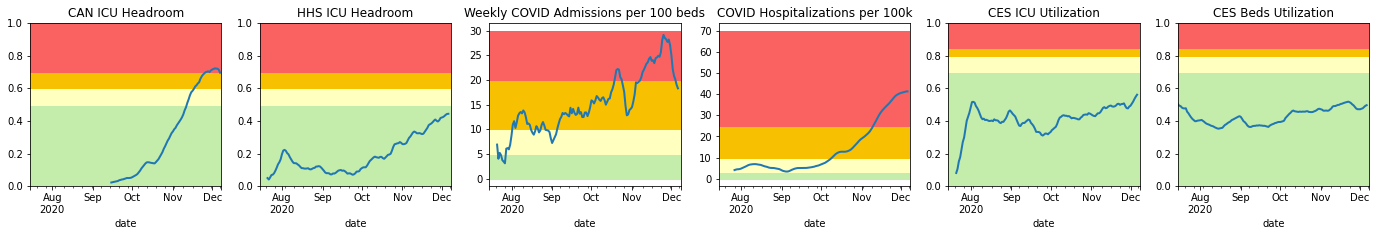

In [368]:
for state in data.index.get_level_values('state').unique().tolist():
    show_state_charts(state)